In [7]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")

In [5]:
def eclairys_v3(stock_ticker, market_ticker, short_period=[5, 10, 20], long_period=[50, 100, 200]):
    """
    #### Description:
    Calculates trend analysis indicators (GRADE and GPS) for a specified stock and market comparison, including:
    - 'GRADE': A scoring metric derived from normalized MAD values across all periods.
    - 'Absolute GPS' and 'Market GPS': Category classifications indicating trend direction and strength 
      based on booleanized MAD values for short and long periods.
    
    #### Parameters:
    - stock_ticker (str): The stock ticker symbol for trend analysis.
    - market_ticker (str): The market index ticker symbol for relative trend analysis.
    - short_period (list): List of short periods for moving average calculation.
    - long_period (list): List of long periods for moving average calculation.

    #### Returns:
    - DataFrame: Combined DataFrame containing trend indicators for stock and market.
    """
    
    # Fetch historical price data for the stock and market
    stock_history = yf.Ticker(stock_ticker).history('max')['Close'].tz_localize(None).dropna()
    stock_history.name = stock_ticker
    market_history = yf.Ticker(market_ticker).history('max')['Close'].tz_localize(None).dropna()
    market_history.name = market_ticker
    period_list = short_period + long_period

    # Initialize DataFrames to store Moving Averages (MA), Moving Average Differentials (MAD), and normalized MAD (MADN)
    MA_df, MAD_df, MADN_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # Calculate indicators for the stock
    for period in period_list:
        if stock_history.empty or len(stock_history) < period:  # Check if enough data exists for the period
            # If not enough data, fill with NaN
            MA_df[period] = np.nan
            MAD_df[period] = np.nan
            MADN_df[period] = np.nan
        else:
            # Calculate Moving Average (MA) and drop NaN values
            MA = stock_history.rolling(period).mean().dropna()
            MA_df[f'MA {period}'] = MA
            
            # Calculate Moving Average Differential (MAD) as the difference over 5 periods
            MAD = MA.diff(5).dropna()
            MAD_df[period] = MAD
            
        MAD_max = MAD_df.rolling(200).max()
        MAD_min = MAD_df.rolling(200).min()

        MADN_df = 100 * (MAD_df - MAD_min) / (MAD_max - MAD_min)

    # Calculate the GRADE score as the mean of MADN values across all periods
    MADN_df = MADN_df.dropna()
    GRADE = MADN_df.mean(axis=1)
    GRADE.name = 'GRADE'

    # Generate GPS indicator based on booleanized MAD values
    if GRADE.empty:
        absolute_GPS = pd.Series(dtype='object')
    else:
        # Convert MAD values to boolean values: 1 if positive, 0 if negative
        BMAD = (MAD_df >= 0).astype(int)
        
        # Sum boolean values for short and long periods separately
        SBMAD = BMAD[short_period].sum(axis=1).reindex(stock_history.index, fill_value=0)
        LBMAD = BMAD[long_period].sum(axis=1).reindex(stock_history.index, fill_value=0)

        # Define GPS conditions based on the sums of short and long period boolean MADs
        conditions = [
            (SBMAD >= 2) & (LBMAD >= 2),
            (SBMAD < 2) & (LBMAD < 2),
            (SBMAD >= 2) & (LBMAD < 2),
            (SBMAD < 2) & (LBMAD >= 2)
        ]
        choices = ['A', 'B', 'C', 'P']
        
        # Assign GPS categories based on conditions
        absolute_GPS = pd.Series(np.select(conditions, choices, default=None), index=stock_history.index, name='Absolute GPS')
        absolute_GPS = absolute_GPS.loc[GRADE.index[0]:]

    # Combine stock indicators into a DataFrame
    output = pd.concat([pd.DataFrame(stock_history), MA_df, pd.DataFrame(GRADE), pd.DataFrame(absolute_GPS)], axis=1)
    
    # Calculate indicators for the market comparison (relative trend between stock and market)
    relative_history = stock_history / market_history
    MA_df, MAD_df = pd.DataFrame(), pd.DataFrame()
    
    for period in period_list:
        if relative_history.empty or len(relative_history) < period:  # Check if enough data exists for the period
            # If not enough data, fill with NaN
            MA_df[period] = np.nan
            MAD_df[period] = np.nan
        else:
            # Calculate Moving Average (MA) for relative trend
            MA = relative_history.rolling(period).mean().dropna()
            MA_df[f'MA {period}'] = MA
            
            # Calculate Moving Average Differential (MAD) as the difference over 5 periods
            MAD = MA.diff(5).dropna()
            MAD_df[period] = MAD
    
    # Generate Market GPS indicator based on booleanized MAD values for relative trend
    if GRADE.empty:
        market_GPS = pd.Series(dtype='object')
    else:
        BMAD = (MAD_df >= 0).astype(int)
        SBMAD = BMAD[short_period].sum(axis=1).reindex(relative_history.index, fill_value=0)
        LBMAD = BMAD[long_period].sum(axis=1).reindex(relative_history.index, fill_value=0)

        # Define GPS categories based on conditions for the relative trend
        conditions = [
            (SBMAD >= 2) & (LBMAD >= 2),
            (SBMAD < 2) & (LBMAD < 2),
            (SBMAD >= 2) & (LBMAD < 2),
            (SBMAD < 2) & (LBMAD >= 2)
        ]
        choices = ['A', 'B', 'C', 'P']
        
        # Assign Market GPS categories based on conditions
        market_GPS = pd.Series(np.select(conditions, choices, default=None), index=relative_history.index, name='Market GPS')
        market_GPS = market_GPS.loc[absolute_GPS.index[0]:]
    
    # Combine stock and market GPS indicators into a single DataFrame
    output = pd.concat([output, market_GPS], axis=1)
    return output

In [6]:
#Exemple d'utilisation eclairys_v3
eclairys_v3('AAPL', '^GSPC')

,AAPL,MA 5,MA 10,MA 20,MA 50,MA 100,MA 200,GRADE,Absolute GPS,Market GPS
Date,,,,,,,,,,
1980-12-12,0.098834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.093678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.086802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.088951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.091530,0.091959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-11-06,222.475235,223.154483,227.364853,229.743236,226.607087,223.438367,202.110470,31.418978,P,B
2024-11-07,227.229996,223.468137,227.056190,229.665321,226.626865,223.548850,202.278861,31.105964,P,B
2024-11-08,226.960007,224.327133,226.636623,229.648325,226.575316,223.680380,202.447544,33.400642,P,B


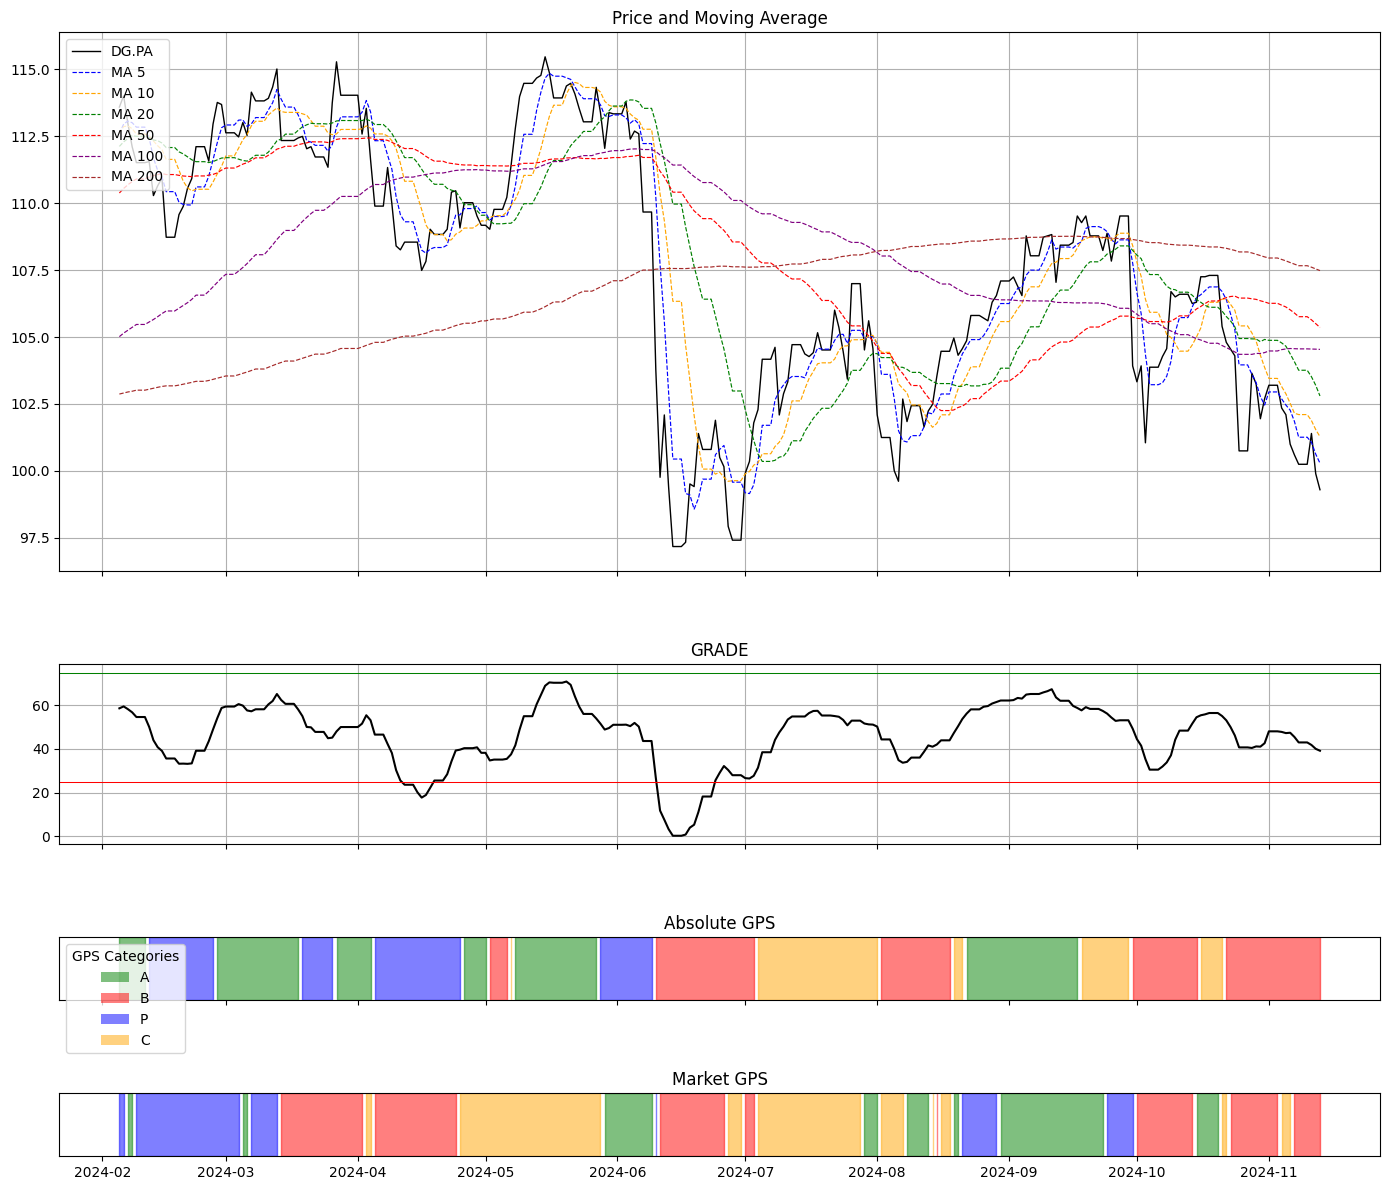

In [9]:
stock_ticker = 'DG.PA'
market_ticker = '^FCHI'

df = eclairys_v3(stock_ticker, market_ticker)
df = df.iloc[-200:]
df = df.resample('D').ffill()

# Create figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 0.35, 0.35]})

# 1st plot: TSLA Price and Moving Averages
ax1.plot(df.index, df[stock_ticker], label=stock_ticker, color='black', linewidth=1)
ax1.plot(df.index, df['MA 5'], label='MA 5', linestyle='--', color='blue', linewidth=0.85)
ax1.plot(df.index, df['MA 10'], label='MA 10', linestyle='--', color='orange', linewidth=0.85)
ax1.plot(df.index, df['MA 20'], label='MA 20', linestyle='--', color='green', linewidth=0.85)
ax1.plot(df.index, df['MA 50'], label='MA 50', linestyle='--', color='red', linewidth=0.85)
ax1.plot(df.index, df['MA 100'], label='MA 100', linestyle='--', color='purple', linewidth=0.85)
ax1.plot(df.index, df['MA 200'], label='MA 200', linestyle='--', color='brown', linewidth=0.85)
ax1.legend(loc='upper left')
ax1.set_title('Price and Moving Average')
ax1.grid(True)

# 2nd plot: GRADE
ax2.plot(df.index, df['GRADE'], color='black')
ax2.axhline(y=75, color='green', linewidth=0.75)
ax2.axhline(y=25, color='red', linewidth=0.75)
ax2.set_title('GRADE')
ax2.grid(True)

# 3rd plot: GPS with color bands
gps_colors = {'A': 'green', 'B': 'red', 'P': 'blue', 'C': 'orange'}
for grade, color in gps_colors.items():
    mask = df['Absolute GPS'] == grade
    ax3.fill_between(df.index, 0, 1, where=mask, color=color, alpha=0.5, transform=ax3.get_xaxis_transform())
ax3.set_title('Absolute GPS')
ax3.set_yticks([])

# 4th plot: Market GPS with color bands
for grade, color in gps_colors.items():
    mask = df['Market GPS'] == grade
    ax4.fill_between(df.index, 0, 1, where=mask, color=color, alpha=0.5, transform=ax4.get_xaxis_transform())
ax4.set_title('Market GPS')
ax4.set_yticks([])

# Add GPS legend
legend_elements = [Patch(facecolor='green', label='A', alpha=0.5),
                   Patch(facecolor='red', label='B', alpha=0.5),
                   Patch(facecolor='blue', label='P', alpha=0.5),
                   Patch(facecolor='orange', label='C', alpha=0.5)]
ax3.legend(handles=legend_elements, loc='upper left', title='GPS Categories')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()